Author: Sasank Chilamkurthy <https://chsasank.github.io>_

Data source : https://www.kaggle.com/techsash/waste-classification-data

### _1. Data introduction_

* DATASET : Training data - 22,564 images(85%) / Validation data - 2,513 images(15%)
* DATA CLASSES : 'Organic' = 'O' / 'Recyclable' = 'R'

* Validation Accuracy

Finetuning the convnet : 94.3%

ConvNet as fixed feature extractor : 92.6%

In [5]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
%matplotlib inline

plt.ion()

In [6]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224), 
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
    ]), 
    'val': transforms.Compose([
        transforms.Resize(256), 
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = './DATASET'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

cuda = torch.cuda.is_available()
print('CUDA:', cuda)

CUDA: True


In [36]:
image_datasets['train'].classes

['O', 'R']

In [40]:
len(image_datasets['train'])

22564

In [41]:
len(image_datasets['val'])

2513

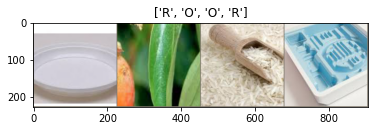

In [11]:
def imshow(inp, title=None):
    
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  

inputs, classes = next(iter(dataloaders['train']))

out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

### 2. Training the model

In [60]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  
            else:
                model.eval()  

            running_loss = 0.0
            running_corrects = 0

           
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

               
                optimizer.zero_grad()

                
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    model.load_state_dict(best_model_wts)
    return model

In [61]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [62]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)

if cuda:
    model_ft = model_ft.cuda()

criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

##### Validation accuracy =  94.3%

In [19]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=5)

Epoch 0/4
----------
train Loss: 0.3265 Acc: 0.8735
val Loss: 0.2561 Acc: 0.9312

Epoch 1/4
----------
train Loss: 0.2793 Acc: 0.8931
val Loss: 0.5321 Acc: 0.8273

Epoch 2/4
----------
train Loss: 0.2600 Acc: 0.8987
val Loss: 0.1686 Acc: 0.9435

Epoch 3/4
----------
train Loss: 0.2441 Acc: 0.9059
val Loss: 0.1712 Acc: 0.9419

Epoch 4/4
----------
train Loss: 0.2344 Acc: 0.9094
val Loss: 0.2874 Acc: 0.9228

Training complete in 134m 5s
Best val Acc: 0.943494


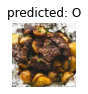

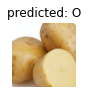

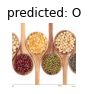

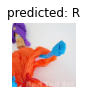

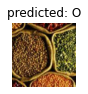

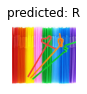

In [20]:
visualize_model(model_ft)

### 3. ConvNet as fixed feature extractor

In [21]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()


optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

##### Validation accuracy = 92.6%

In [23]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=5)

Epoch 0/4
----------
train Loss: 0.5337 Acc: 0.7954
val Loss: 0.2452 Acc: 0.9133

Epoch 1/4
----------
train Loss: 0.5143 Acc: 0.8043
val Loss: 0.2572 Acc: 0.8957

Epoch 2/4
----------
train Loss: 0.5161 Acc: 0.8047
val Loss: 0.2498 Acc: 0.9117

Epoch 3/4
----------
train Loss: 0.5233 Acc: 0.8069
val Loss: 0.2483 Acc: 0.9129

Epoch 4/4
----------
train Loss: 0.5402 Acc: 0.8022
val Loss: 0.2101 Acc: 0.9260

Training complete in 25m 54s
Best val Acc: 0.925985


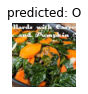

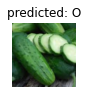

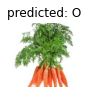

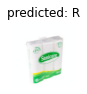

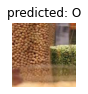

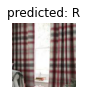

In [24]:
visualize_model(model_conv)

plt.ioff()
plt.show()